<a href="https://colab.research.google.com/github/jong9810/TensorFlow-2.0/blob/main/12_2_Kaggle_Data_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Data를 활용한 예제1 : Surface Crack Detection
- Surface Crack Detection 데이터 : 콘크리트 표면 결함을 발견하고 예측하기 위한 Kaggle의 공개 데이터이다.
- 평균적으로 227 * 227 크기를 가지는 color 이미지이며, crack이 없는 Negative 데이터 2만 개와 crack이 발생한 Positive 데이터 2만개로 총 4만 개의 이미지 데이터를 포함하고 있다.

# 모델 아키텍처
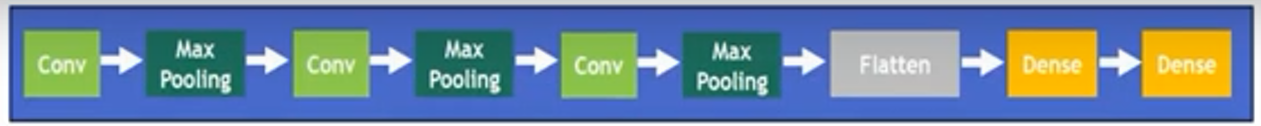

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.__version__

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
import shutil # 파일 복사 등에 사용하는 모듈
import os

try:
    dataset_path = '/content/gdrive/My Drive/Colab Notebooks/dataset'
    # dataset_path에 있는 'surface_crack.zip' 파일을 colab의 '/content' 에 복사함
    shutil.copy(os.path.join(dataset_path, 'surface_crack.zip'), '/content')

except Exception as err:
    print(str(err))

In [ ]:
# 디렉토리 경로를 아래와 같이 정의해주면 다른 프로젝트를 진행할 때 호환성이 좋아진다.
ROOT_DIR = '/content'
DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'surface_crack')
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'test')

In [ ]:
import zipfile

with zipfile.ZipFile(os.path.join(ROOT_DIR, 'surface_crack.zip'), 'r') as target_file:
    # 압축 파일을 해제하여 저장할 경로를 지정하는데, 만약 경로 디렉토리(폴더)가 없을 경우 파일을 생성한다?
    target_file.extractall(DATA_ROOT_DIR)

In [ ]:
label_name_list = os.listdir(DATA_ROOT_DIR)
print(label_name_list)

for label_name in label_name_list:
    label_dir = os.path.join(DATA_ROOT_DIR, label_name)
    print('train label : ' + label_name + ' => ', len(os.listdir(os.path.join(DATA_ROOT_DIR, label_name))))

In [ ]:
# 방법1 : Train 디렉토리 생성
try:
    # shutil.copytree(경로1, 경로2) : 경로1에 있는 하위 디렉토리를 모두 복사하여 경로2의 하위 디렉토리에 붙여넣음
    shutil.copytree(DATA_ROOT_DIR, TRAIN_DATA_ROOT_DIR)

except Exception as err:
    print(str(err))

In [ ]:
# 방법2 : Test 디렉토리 생성
if not os.path.exists(TEST_DATA_ROOT_DIR):
    os.mkdir(TEST_DATA_ROOT_DIR)

if not os.path.exists(os.path.join(TEST_DATA_ROOT_DIR, 'Positive')):
    os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'Positive'))

if not os.path.exists(os.path.join(TEST_DATA_ROOT_DIR, 'Negative')):
    os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'Negative'))

In [ ]:
import random

MOVE_RATIO = 0.2
label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:
    src_dir_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name) # '/content/surface_crack/train/(Positive and Negative)
    dst_dir_path = os.path.join(TEST_DATA_ROOT_DIR, label_name) # '/content/surface_crack/test/(Positive and Negative)

    # shuffle data => 데이터의 다양성을 확보하기 위해 shuffle 해줌
    train_data_file_list = os.listdir(src_dir_path)
    random.shuffle(train_data_file_list)

    split_num = int(MOVE_RATIO * len(train_data_file_list))
    test_data_file_list = train_data_file_list[0:split_num]

    for test_data_file in test_data_file_list:
        
        try:
            # train 디렉토리에서 20% 비율 만큼 test 디렉토리로 이동
            shutil.move(os.path.join(src_dir_path, test_data_file), os.path.join(dst_dir_path, test_data_file))
        
        except Exception as err:
            print(str(err))

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# 데이터 전처리 (정규화)
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.20)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.20)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# 데이터 전체 개수가 많기 때문에 이미지 사이즈를 224 * 224 등으로 크게 하면 Memory Fail이 발생할 수 있다. (이미지 크기가 너무 커서 메모리 할당 실패)
IMG_WIDTH = 128
IMG_HEIGHT = 128

train_generator = train_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode='rgb', class_mode='sparse', target_size=(IMG_WIDTH, IMG_HEIGHT), subset='training')
validation_generator = validation_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode='rgb', class_mode='sparse', target_size=(IMG_WIDTH, IMG_HEIGHT), subset='validation')
test_generator = test_datagen.flow_from_directory(TEST_DATA_ROOT_DIR, batch_size=32, color_mode='rgb', class_mode='sparse', target_size=(IMG_WIDTH, IMG_HEIGHT))

In [ ]:
print(train_generator.class_indices, train_generator.num_classes)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# 모델 구축
class_nums = train_generator.num_classes

model = Sequential()

model.add(Conv2D(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), kernel_size=(3,3), filters=32, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(kernel_size=(3,3), filters=32, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(kernel_size=(3,3), filters=32, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(class_nums, activation='softmax'))

# 참고) 학습율 default 값은 1e-3이다.
model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
hist = model.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=[earlystopping])

In [ ]:
model.evaluate(test_generator)

In [ ]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')

plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')

plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

### predict()함수를 이용해 예측해본 후 정답과 비교

In [ ]:
# pred = model.predict(train_generator[:25])
# pred

In [ ]:
# plt.figure(figsize=(9,9))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     plt.imshow(train_generator[i])